<a href="https://colab.research.google.com/github/28nahidhasan/Thesis-Summer-24-25-/blob/main/Data_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pickle
from google.colab import drive, files
from PIL import Image
import datetime



In [2]:
# current date and time
print(f"Processing started at: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

# Mount Google Drive
drive.mount('/content/drive')

# Define dataset path
dataset_path = '/content/drive/My Drive/Thesis/Thesis Pictures'

# Verify dataset folder exists
if not os.path.exists(dataset_path):
    raise FileNotFoundError("Dataset folder not found. Check the path or permissions.")

# List categories
categories = [f for f in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, f))]
print("Categories found:", categories)

# Load images, labels, and metadata
IMG_SIZE = (224, 224)
images = []
labels = []
image_metadata = []

for category in categories:
    folder_path = os.path.join(dataset_path, category)
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        if os.path.isdir(img_path):
            print(f"Skipping directory: {img_path}")
            continue
        try:
            with Image.open(img_path) as img:
                img.verify()
        except Exception as e:
            print(f"Invalid image file: {img_path}, Error: {e}")
            continue
        try:
            img = cv2.imread(img_path)
            if img is None:
                print(f"Failed to load image: {img_path}")
                continue
            images.append(img)
            labels.append(category)
            image_metadata.append({'file_path': img_path, 'label': category})
        except Exception as e:
            print(f"Error processing {img_path}: {e}")

print(f"Loaded {len(images)} images")


Processing started at: 2025-07-21 17:09:10
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Categories found: ['Powdery mildew', 'Thrips (Western flower thrips)', 'Phytophthora bligh', 'Flea beetles', 'Squash vine borer', 'Squash bug', 'Southern blight', 'Gummy stem blight', 'Fusarium', 'mosaic', 'Armyworms', 'Bacterial leaf spot', 'Bacterial wilt', 'Aphids', 'Cabbage looper', 'Cucumber beetles', 'Alternaria leaf blight', 'Alternaria cucumerina']
Loaded 1692 images


In [3]:
# Resize all images to 224x224
images_resized = []
for img in images:
    img_resized = cv2.resize(img, IMG_SIZE)
    images_resized.append(img_resized)
images = np.array(images_resized)
print("Images resized to", IMG_SIZE)

Images resized to (224, 224)


In [4]:
# Color Space Conversion (Convert BGR to RGB)
images_rgb = []
for img in images:
    # Convert image data type to uint8 before color conversion
    img_uint8 = img.astype(np.uint8)
    img_rgb = cv2.cvtColor(img_uint8, cv2.COLOR_BGR2RGB)
    images_rgb.append(img_rgb)
images = np.array(images_rgb)
print("Images converted to RGB")

Images converted to RGB


In [5]:
# Data Cleaning (Remove images with incorrect shapes or invalid values)
valid_images = []
valid_labels = []
valid_metadata = []
for i, (img, label, meta) in enumerate(zip(images, labels, image_metadata)):
    if img.shape == (224, 224, 3) and not np.any(np.isnan(img)):
        valid_images.append(img)
        valid_labels.append(label)
        valid_metadata.append(meta)
    else:
        print(f"Removing invalid image: {meta['file_path']}")
images = np.array(valid_images)
labels = np.array(valid_labels)
image_metadata = valid_metadata
print(f"After cleaning, {len(images)} images remain")

After cleaning, 1692 images remain


In [6]:
# Normalization (values to 0, 1 )
images_normalized = images / 255.0
print("Images normalized to range [0, 1]")

Images normalized to range [0, 1]


In [7]:
# Cropping (200x200 region)
CROP_SIZE = (200, 200)
images_cropped = []
for img in images_normalized:
    h, w = img.shape[:2]
    start_x = (w - CROP_SIZE[0]) // 2
    start_y = (h - CROP_SIZE[1]) // 2
    img_cropped = img[start_y:start_y + CROP_SIZE[1], start_x:start_x + CROP_SIZE[0]]
    images_cropped.append(img_cropped)
images = np.array(images_cropped)
print(f"Images cropped to {CROP_SIZE}")


Images cropped to (200, 200)


In [8]:
# Padding (restore to 224x224)
PADDED_SIZE = (224, 224)
images_padded = []
for img in images:
    h, w = img.shape[:2]
    top_pad = (PADDED_SIZE[1] - h) // 2
    bottom_pad = PADDED_SIZE[1] - h - top_pad
    left_pad = (PADDED_SIZE[0] - w) // 2
    right_pad = PADDED_SIZE[0] - w - left_pad
    img_padded = np.pad(
        img,
        ((top_pad, bottom_pad), (left_pad, right_pad), (0, 0)),
        mode='constant',
        constant_values=0
    )
    images_padded.append(img_padded)
images = np.array(images_padded)
print(f"Images padded to {PADDED_SIZE}")

Images padded to (224, 224)


In [9]:
# Data Augmentation Setup
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest'
)
# Fit datagen to padded images
datagen.fit(images)
print("Data augmentation configured")

Data augmentation configured


In [10]:
# Shuffling
images, labels, image_metadata = shuffle(images, labels, image_metadata, random_state=42)
print("Dataset shuffled")

Dataset shuffled


In [11]:
#  Encode Labels (Convert categorical labels to numerical)
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
print("Label classes:", label_encoder.classes_)
print("Shape of images array:", images.shape)
print("Shape of labels array:", labels_encoded.shape)


Label classes: ['Alternaria cucumerina' 'Alternaria leaf blight' 'Aphids' 'Armyworms'
 'Bacterial leaf spot' 'Bacterial wilt' 'Cabbage looper'
 'Cucumber beetles' 'Flea beetles' 'Fusarium' 'Gummy stem blight'
 'Phytophthora bligh' 'Powdery mildew' 'Southern blight' 'Squash bug'
 'Squash vine borer' 'Thrips (Western flower thrips)' 'mosaic']
Shape of images array: (1692, 224, 224, 3)
Shape of labels array: (1692,)


In [12]:
# Analyze Class Distribution
unique, counts = np.unique(labels, return_counts=True)
class_distribution = dict(zip(unique, counts))
print("Class distribution:", class_distribution)

# Save class distribution
with open('/content/class_distribution.txt', 'w') as f:
    f.write(str(class_distribution))
print("Class distribution saved to /content/class_distribution.txt")

# Calculate class weights
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(labels_encoded), y=labels_encoded)
class_weights_dict = dict(enumerate(class_weights))
print("Class weights:", class_weights_dict)

# Save preprocessed images
np.save('/content/images_preprocessed.npy', images)
print("Preprocessed images saved to /content/images_preprocessed.npy")

# Save encoded labels
np.save('/content/labels_encoded.npy', labels_encoded)
print("Encoded labels saved to /content/labels_encoded.npy")

# Save label encoder
with open('/content/label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)
print("Label encoder saved to /content/label_encoder.pkl")

# Save class weights
with open('/content/class_weights.pkl', 'wb') as f:
    pickle.dump(class_weights_dict, f)
print("Class weights saved to /content/class_weights.pkl")

# Convert metadata to DataFrame
metadata_df = pd.DataFrame(image_metadata)
# Add encoded labels
metadata_df['encoded_label'] = labels_encoded
# Save to CSV
csv_path = '/content/image_metadata.csv'
metadata_df.to_csv(csv_path, index=False)
print(f"Image metadata saved to {csv_path}")


Class distribution: {np.str_('Alternaria cucumerina'): np.int64(99), np.str_('Alternaria leaf blight'): np.int64(117), np.str_('Aphids'): np.int64(68), np.str_('Armyworms'): np.int64(100), np.str_('Bacterial leaf spot'): np.int64(100), np.str_('Bacterial wilt'): np.int64(115), np.str_('Cabbage looper'): np.int64(69), np.str_('Cucumber beetles'): np.int64(138), np.str_('Flea beetles'): np.int64(112), np.str_('Fusarium'): np.int64(103), np.str_('Gummy stem blight'): np.int64(100), np.str_('Phytophthora bligh'): np.int64(100), np.str_('Powdery mildew'): np.int64(39), np.str_('Southern blight'): np.int64(40), np.str_('Squash bug'): np.int64(104), np.str_('Squash vine borer'): np.int64(103), np.str_('Thrips (Western flower thrips)'): np.int64(114), np.str_('mosaic'): np.int64(71)}
Class distribution saved to /content/class_distribution.txt
Class weights: {0: np.float64(0.9494949494949495), 1: np.float64(0.8034188034188035), 2: np.float64(1.3823529411764706), 3: np.float64(0.94), 4: np.float

Successfully loaded .npy files


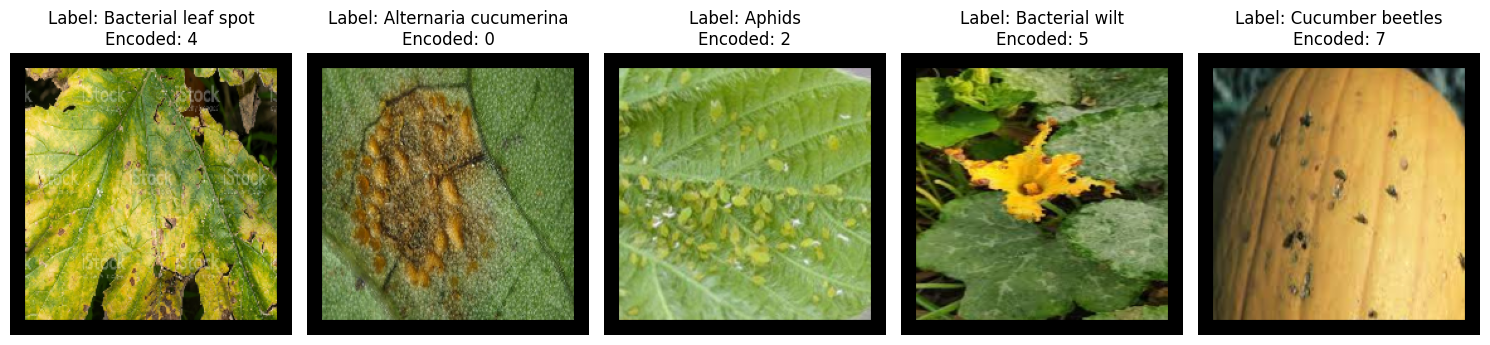

Displayed 5 sample images from images_preprocessed.npy
Sample encoded labels from labels_encoded.npy: [4 0 2 5 7]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

All preprocessed files downloaded
Processing completed at: 2025-07-21 17:13:21


In [13]:
# Display Contents of .npy Files
try:
    images_preprocessed = np.load('/content/images_preprocessed.npy')
    labels_encoded = np.load('/content/labels_encoded.npy')
    print("Successfully loaded .npy files")
except Exception as e:
    print(f"Error loading .npy files: {e}")
    raise

# Display sample images with labels
num_samples = min(5, len(images_preprocessed))  # Show up to 5 images
plt.figure(figsize=(15, 5))
for i in range(num_samples):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(images_preprocessed[i])
    label_name = label_encoder.inverse_transform([labels_encoded[i]])[0]
    plt.title(f"Label: {label_name}\nEncoded: {labels_encoded[i]}")
    plt.axis('off')
plt.tight_layout()
plt.show()
print(f"Displayed {num_samples} sample images from images_preprocessed.npy")

# Print sample label values
print("Sample encoded labels from labels_encoded.npy:", labels_encoded[:num_samples])

# Download Preprocessed Files
try:
    files.download('/content/image_metadata.csv')
    files.download('/content/images_preprocessed.npy')
    files.download('/content/labels_encoded.npy')
    files.download('/content/label_encoder.pkl')
    files.download('/content/class_weights.pkl')
    files.download('/content/class_distribution.txt')
    print("All preprocessed files downloaded")
except Exception as e:
    print(f"Error downloading files: {e}")

# Log completion time
print(f"Processing completed at: {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")